In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# 确保支持中文绘图
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

# 导入自定义模块
# 假设当前目录已经是 d:\degree_code\scheme_1_PID
try:
    from pid import MultiLoopPID, PIDController
    from greenhouse_env import VirtualGreenhouse
    from MOSSA import MOSSA # 导入新实现的多目标优化算法
except ImportError:
    # 如果直接运行notebook找不到模块，添加当前路径到sys.path
    sys.path.append(os.getcwd())
    from pid import MultiLoopPID, PIDController
    from greenhouse_env import VirtualGreenhouse
    from MOSSA import MOSSA

In [2]:
from abc import ABC, abstractmethod
import sys
import os
import numpy as np
import torch
# Try to import TPLC-related modules if available
try:
    from tplc_algo.models.tplc_model import TPLCNet
    from tplc_algo.utils.scaler import NumpyStandardScaler
except ImportError:
    pass

# --- 1. Define GreenhousePredictor Base Class ---
class GreenhousePredictor(ABC):
    @abstractmethod
    def predict_next_step(self, current_state, control_actions, external_weather, history=None):
        """
        Predict the next state of the greenhouse.
        
        Args:
            current_state: tuple (temp, rh, co2)
            control_actions: tuple (u_temp, u_rh)
            external_weather: tuple (ext_temp, ext_rh)
            history: Optional history buffer for sequence models
            
        Returns:
            next_state: tuple (temp, rh, co2)
            new_history: Updated history buffer (optional)
        """
        pass

# --- 2. Define TPLCNetPredictor Class ---
class TPLCNetPredictor(GreenhousePredictor):
    def __init__(self, model_path, fallback_env_model=None):
        self.use_fallback = False
        self.fallback_model = fallback_env_model
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Try to import TPLC-Net path
        target_path = r'd:\degree_code_scheme_1\scheme_1\TPLC_Net'
        if os.path.exists(target_path) and target_path not in sys.path:
            sys.path.append(target_path)
            
        try:
            from tplc_algo.models.tplc_model import TPLCNet
            
            # Model Params (Hardcoded based on typical config)
            self.seq_len = 96
            self.pred_len = 24
            self.input_dim = 49 # greenhouse dataset cols
            self.target_dim = 3
            
            # Init Model
            self.model = TPLCNet(
                input_dim=self.input_dim,
                target_dim=self.target_dim,
                seq_len=self.seq_len,
                pred_len=self.pred_len,
                num_scales=2,
                top_k_periods=3,
                hidden_dim=64
            ).to(self.device)
            
            # Load Checkpoint
            if os.path.exists(model_path):
                print(f"Loading TPLC-Net from {model_path}...")
                ckpt = torch.load(model_path, map_location=self.device)
                self.model.load_state_dict(ckpt)
                self.model.eval()
            else:
                print(f"Warning: Model file not found at {model_path}")
                self.use_fallback = True

            # Scaler placeholder (In real app, load from disk)
            # We assume inputs are standard normalized.
            # Here we define rough mean/std for T, RH, CO2 to de-normalize outputs
            # Tair ~ 20, Rh ~ 70, CO2 ~ 600
            self.mean_vals = np.zeros(self.input_dim)
            self.std_vals = np.ones(self.input_dim)
            
            # Simple heuristic for key variables
            self.idx_map = {'Tair': 10, 'Rhair': 9, 'CO2air': 2}
            self.mean_vals[10] = 22.0; self.std_vals[10] = 5.0
            self.mean_vals[9] = 75.0;  self.std_vals[9] = 15.0
            self.mean_vals[2] = 500.0; self.std_vals[2] = 200.0
            
        except Exception as e:
            print(f"Failed to load TPLC-Net: {e}")
            print("Running in Placeholder Mode.")
            self.use_fallback = True

    def _map_to_features(self, current_state, control_actions, external_weather):
        """Map simplified demo state to full 49-dim feature vector"""
        features = np.zeros(self.input_dim)
        
        curr_t, curr_rh, curr_co2 = current_state
        u_temp, u_rh = control_actions
        
        # Fill State
        features[10] = curr_t    # Tair
        features[9] = curr_rh    # Rhair
        features[2] = curr_co2   # CO2air
        
        # Fill Control (Heuristic)
        if u_temp > 0: features[7] = u_temp  # PipeGrow
        else: features[14] = abs(u_temp)     # VentLee
        
        # We leave others as 0 (mean)
        return features

    def predict_next_step(self, current_state, control_actions, external_weather, history=None):
        if self.use_fallback and self.fallback_model:
            # Unpack
            curr_t = current_state[0]
            curr_rh = current_state[1]
            curr_co2 = current_state[2] if len(current_state) > 2 else 400.0
            
            u_t, u_rh = control_actions
            ext_t, ext_rh = external_weather
            
            # Physics from the fallback model (EnhancedGreenhouse parameters)
            alpha_t, beta_t = self.fallback_model.alpha_t, self.fallback_model.beta_t
            alpha_h, beta_h = self.fallback_model.alpha_h, self.fallback_model.beta_h
            
            d_t = alpha_t * (ext_t - curr_t) + beta_t * u_t
            d_r = alpha_h * (ext_rh - curr_rh) + beta_h * u_rh
            
            next_t = curr_t + d_t
            next_r = curr_rh + d_r
            next_co2 = curr_co2 
            
            # In fallback mode, history update is trivial/ignored
            return (next_t, next_r, next_co2), history
        else:
            # Real Inference
            # 1. Update History
            features = self._map_to_features(current_state, control_actions, external_weather)
            
            if history is None:
                # Cold start: repeat current state
                history = np.tile(features, (self.seq_len, 1))
            
            # Append new features (Shift and replace last)
            new_history = np.roll(history, -1, axis=0)
            new_history[-1] = features
            
            # 2. Prepare Tensor
            x_np = (new_history - self.mean_vals) / self.std_vals
            x = torch.tensor(x_np, dtype=torch.float32).unsqueeze(0).to(self.device) # [1, 96, 49]
            
            # 3. Predict
            with torch.no_grad():
                y_pred = self.model(x) # [1, 24, 3] usually
                
            # 4. Extract next step (first step of prediction)
            # Output is normally strictly target cols, or all cols? 
            # TPLCNet output_dim = target_dim = 3
            # We assume output order is T, Rh, CO2 (based on target_cols preferred list)
            
            pred_vals = y_pred[0, 0, :].cpu().numpy()
            
            # Denormalize (assuming target index order matches logic: Tair, Rhair, CO2air)
            # Actually Pipeline defaults: Tair, Rhair, CO2air.
            
            next_t = pred_vals[0] * self.std_vals[10] + self.mean_vals[10]
            next_r = pred_vals[1] * self.std_vals[9] + self.mean_vals[9]
            next_co2 = pred_vals[2] * self.std_vals[2] + self.mean_vals[2]
            
            return (next_t, next_r, next_co2), new_history

In [3]:
class TomatoYieldModel:
    """
    简化的番茄产量模型 (基于 Vanthoor et al. 的逻辑简化)
    """
    def __init__(self):
        # 光合作用参数
        self.c_alpha = 0.05 # 冠层光量子效率 (mg CO2 / J PAR)
        self.c_resp = 0.01  # 维持呼吸系数
        self.harvest_index = 0.7 # 干物质转化为果实的比例
        
    def calculate_yield(self, temp, par, co2):
        """
        计算单步产量增量
        Args:
            temp: 温度 (C)
            par: 光合有效辐射 (W/m2)
            co2: CO2浓度 (ppm)
        Returns:
            yield_inc: 产量增量 (g/m2)
        """
        # 1. 温度修正函数 (最佳温度 ~24度)
        temp_effect = np.exp(-((temp - 24)**2) / 50)
        
        # 2. CO2 修正函数 (饱和效应)
        co2_effect = (co2) / (co2 + 400) # Michaelis-Menten kinetic like
        
        # 3. 光合作用速率 (简化的冠层光合模型)
        # Pg = c_alpha * PAR * f(T) * f(CO2)
        pg = self.c_alpha * par * temp_effect * co2_effect
        
        # 4. 呼吸消耗
        resp = self.c_resp * (2 ** ((temp - 25)/10))
        
        # 5. 净同化量
        net_assim = max(0, pg - resp)
        
        # 6. 产量增量
        yield_inc = net_assim * self.harvest_index
        
        return yield_inc

class EnergyCostModel:
    """
    能耗成本模型
    """
    def __init__(self):
        self.price_heat = 0.05 # be/kWh
        self.price_elec = 0.12 # per kWh
        
    def calculate_cost(self, u_temp, u_rh):
        """
        计算单步能耗成本
        Args:
            u_temp: 温度控制量 (-100 ~ 100). >0 加热, <0 通风/制冷
            u_rh: 湿度控制量 (-100 ~ 100). >0 加湿, <0 除湿
        """
        cost = 0.0
        
        # 加热成本
        if u_temp > 0:
            power_heat = u_temp * 0.5 # 假设系数 kW
            cost += power_heat * self.price_heat
            
        # 通风/风机耗电 (制冷或通风)
        if u_temp < 0:
            power_vent = abs(u_temp) * 0.1 # kW
            cost += power_vent * self.price_elec
            
        # 除湿/加湿耗电
        power_hum = abs(u_rh) * 0.15 # kW
        cost += power_hum * self.price_elec
        
        return cost

class EnhancedGreenhouse(VirtualGreenhouse):
    """
    增强版温室模型，增加 PAR 和 CO2 模拟
    """
    def __init__(self, dt=1.0):
        super().__init__(dt)
        self.co2 = 400.0 # ppm
        self.par = 0.0   # W/m2
        
    def get_enviro_vars(self, t):
        # 获取基础 T, RH
        ext_t, ext_rh = self.get_external_weather(t)
        
        # 模拟 PAR (白天有光，中午最强)
        # 假设 t 是分钟, period 1440
        day_time = t % 1440
        if 360 < day_time < 1080: # 6:00 - 18:00
            self.par = 500 * np.sin(np.pi * (day_time - 360) / 720)
        else:
            self.par = 0.0
            
        # 模拟 CO2 (白天消耗，晚上积累)
        if self.par > 50:
            self.co2 -= 1.0 # 光合作用消耗
        else:
            self.co2 += 0.5 # 呼吸作用释放
            
        # 简单的通风恢复
        self.co2 += 0.1 * (400 - self.co2) 
        
        return self.par, self.co2

## 2. 定义适应度函数与滚动优化逻辑

### TPLC-Net 在此模块中的作用
在完整的 Scheme 1 系统中，模块四利用 **TPLC-Net (已训练好的模型)** 作为**系统预测模型 (System Model)**。
*   **输入**: 历史环境序列 + 优化器生成的**未来控制序列** ($u_{t}, ..., u_{t+H}$).
    *   **关键特征**: Tair, Rhair, CO2air (自回归), VentLee, Ventwind (通风), PipeGrow, PipeLow (加热), AssimLight, co2_dos, EnScr, BlackScr (控制), Tot_PAR (光照扰动).
*   **输出**: 预测的**未来环境状态** ($\hat{T}_{t+1:t+H}, \hat{Rh}_{t+1:t+H}, \hat{CO2}_{t+1:t+H}$).
*   **作用**: 它充当了适应度函数中的**模拟器**，告诉 ISSA 算法“如果你使用这组 PID 参数，未来的温度/湿度会变成什么样”。

> **注意**: 为了保证本 Demo 的独立可运行性，我们下方的 `rolling_optimization` 函数中使用了一个**简化的物理公式**来代替 TPLC-Net 进行预测。在实际部署时，应将物理公式替换为 TPLC-Net 的推理接口 (Inference)。

适应度函数 $J$ 用于评估一组 PID 参数的优劣。计算公式为：
$$ J = \sum_{h=1}^{H} \left[ \omega_{T} ( \hat{T}_{t+h} - T_{opt} )^2 + \omega_{Rh} ( \hat{Rh}_{t+h} - Rh_{opt} )^2 \right] $$

In [4]:
def rolling_optimization_mossa(env_model, current_state, pid_controllers, predictor, horizon=10):
    """
    基于 MOSSA 的滚动优化 (多目标: 产量 vs 能耗)
    优化变量: 未来 horizon 步的最佳恒定设定点 (Target_T, Target_RH)
    
    Args:
        env_model: EnhancedGreenhouse instance (仅用于提供时间步等上下文)
        current_state: (temp, rh)
        pid_controllers: (temp_pid, hum_pid) 已调好的控制器
        predictor: GreenhousePredictor instance (用于模拟未来)
        horizon: 预测步长
        
    Returns:
        best_setpoints: 选出的最佳设定点 [opt_t, opt_rh]
        pareto_front: (Solutions, Fitness) 用于可视化
    """
    
    # 实例化模型
    yield_model = TomatoYieldModel()
    energy_model = EnergyCostModel()
    
    # 定义多目标评估函数
    def objective_function(x):
        """
        x: [target_temp, target_rh]
        Returns: [-yield_total, cost_total]
        """
        tgt_t, tgt_r = x
        
        # 模拟上下文初始化
        sim_temp, sim_rh = current_state
        sim_co2 = 400.0 # 简化
        sim_step = env_model.time_step
        
        temp_pid, hum_pid = pid_controllers
        
        # 为了不破坏全局PID状态，假设简单P控制或无状态
        # 实际上严谨做法应拷贝PID
        
        total_yield = 0.0
        total_cost = 0.0
        
        curr_t = sim_temp
        curr_r = sim_rh
        curr_co2 = sim_co2
        
        # TPLC-Net Inference History Buffer
        sim_history = None 
        
        for h in range(horizon):
            # 1. PID 计算控制量 (基于当前状态)
            # 为了模拟，我们创建一个临时的简单响应，或者假设PID参数已知
            sim_pid_t = PIDController(temp_pid.kp, temp_pid.ki, temp_pid.kd, output_limits=(-100, 100))
            sim_pid_h = PIDController(hum_pid.kp, hum_pid.ki, hum_pid.kd, output_limits=(-100, 100))
            
            u_t_val = sim_pid_t.update(tgt_t, curr_t)
            u_r_val = sim_pid_h.update(tgt_r, curr_r)
            
            # 2. 系统/环境 演化 (预测下一刻状态)
            # 获取外部天气 (模拟预测系统的输入)
            ext_t, ext_rh = env_model.get_external_weather(sim_step + h)
            
            # 调用 Predictor (TPLC-Net)
            # 物理公式或 TPLC-Net 推理
            result = predictor.predict_next_step(
                (curr_t, curr_r, curr_co2),
                (u_t_val, u_r_val),
                (ext_t, ext_rh),
                history=sim_history
            )
            
            # 兼容处理返回值 (Tuple + History or just Tuple)
            if isinstance(result, tuple) and len(result) == 2 and isinstance(result[0], tuple):
                 (next_t, next_r, next_co2), sim_history = result
            elif len(result) == 3:
                 next_t, next_r, next_co2 = result
                 # sim_history remains None if not returned
            else:
                 # Fallback if structure is unexpected
                 next_t, next_r, next_co2 = result[0], result[1], result[2]

            # 更新状态
            curr_t = next_t
            curr_r = next_r
            curr_co2 = next_co2
            
            # 3. 计算产量 (需要 PAR)
            day_time = (sim_step + h) % 1440
            par = 500 * np.sin(np.pi * (day_time - 360) / 720) if 360 < day_time < 1080 else 0
            
            y_inc = yield_model.calculate_yield(curr_t, par, curr_co2)
            total_yield += y_inc
            
            # 4. 计算能耗
            c_inc = energy_model.calculate_cost(u_t_val, u_r_val)
            total_cost += c_inc
            
        return np.array([-total_yield, total_cost]) # 最小化
            
        
    # 设置 MOSSA
    # 变量范围: Temp [10, 35], RH [40, 90]
    lb = [10, 40]
    ub = [35, 90]
    
    mossa = MOSSA(obj_func=objective_function, n_dim=2, lb=lb, ub=ub, pop_size=20, max_iter=10, n_obj=2)
    
    # 运行优化
    pareto_X, pareto_F = mossa.run()
    
    # 决策逻辑: 简单的加权 (Profit = Yield * Price - Cost)
    price = 2.0
    
    # pareto_F[:, 0] 是 -Yield
    # pareto_F[:, 1] 是 Cost
    # Profit = (-F0) * Price - F1
    profits = (-pareto_F[:, 0]) * price - pareto_F[:, 1]
    
    best_idx = np.argmax(profits)
    best_setpoint = pareto_X[best_idx]
    
    return best_setpoint, (pareto_X, pareto_F)

## 3. 运行主仿真实验

我们将模拟一天 (24小时) 的控制过程。每小时进行一次参数优化 (简化为了演示速度)。真实的控制频率可能更高 (如每分钟)。

In [5]:
# --- 主程序逻辑 ---

# 1. 初始化环境 (Physical Reality)
env = EnhancedGreenhouse(dt=1.0)
curr_obs = env.reset(init_temp=20.0, init_rh=50.0)

# 2. 初始化预测模型 (Digital Twin / System Model)
# 指向可能存在的 TPLC-Net 路径，如果不存在会自动回退到物理仿真
tplc_model_path = r'd:\degree_code_scheme_1\scheme_1\TPLC_Net\checkpoints\tplcnet_best.pt' 
predictor = TPLCNetPredictor(model_path=tplc_model_path, fallback_env_model=env)

# 3. 初始化底层 PID 控制器
# Kp, Ki, Kd (固定参数)
temp_pid = PIDController(2.0, 0.1, 0.5, output_limits=(-100, 100))
hum_pid = PIDController(1.5, 0.05, 0.2, output_limits=(-100, 100))

# 记录数据
history = {
    'time': [],
    'temp': [], 'rh': [],
    'target_temp': [], 'target_rh': [],
    'u_temp': [], 'u_rh': [],
    'yield': [], 'cost': []
}

# 仿真步数
total_steps = 100 # 模拟 100 分钟
MPC_HORIZON = 5   # 预测未来 5 分钟

print(f"开始仿真: 总步数={total_steps}, MPC预测步长={MPC_HORIZON}")

# 累积变量
acc_yield = 0.0
acc_cost = 0.0

model_yield = TomatoYieldModel()
model_energy = EnergyCostModel()

# 初始设定点
current_target_temp = 25.0
current_target_rh = 60.0

for t in range(total_steps):
    # --- Step 1: MOSSA 滚动优化决策 (MPC层) ---
    # 每 5 步执行一次优化
    if t % 5 == 0:
        print(f"Time {t}: 执行 MOSSA 优化设定点 (using {predictor.__class__.__name__})...")
        # 优化得到最佳设定点，传入 predictor
        best_sp, _ = rolling_optimization_mossa(
            env, 
            (env.temp, env.rh), 
            (temp_pid, hum_pid), 
            predictor,  # <--- 使用 TPLCNetPredictor
            horizon=MPC_HORIZON
        )
        current_target_temp, current_target_rh = best_sp
        print(f"  -> 优化设定点: Temp={current_target_temp:.2f}, RH={current_target_rh:.2f}")

    # --- Step 2: 底层 PID执行控制 (控制层) ---
    u_t = temp_pid.update(current_target_temp, env.temp)
    u_r = hum_pid.update(current_target_rh, env.rh)
    
    # --- Step 3: 真实环境演化 (Reality) ---
    # 注意: 这里 env.step 代表真实物理世界的演变
    # predictor.predict 代表我们在优化算子脑海中的演变
    
    par, co2 = env.get_enviro_vars(t)
    
    obs = env.step(u_t, u_r)
    real_temp, real_rh = obs
    
    # --- Step 4: 统计 ---
    step_yield = model_yield.calculate_yield(real_temp, par, co2)
    step_cost = model_energy.calculate_cost(u_t, u_r)
    
    acc_yield += step_yield
    acc_cost += step_cost
    
    # --- Step 5: 记录 ---
    history['time'].append(t)
    history['temp'].append(real_temp)
    history['rh'].append(real_rh)
    history['target_temp'].append(current_target_temp)
    history['target_rh'].append(current_target_rh)
    history['u_temp'].append(u_t)
    history['u_rh'].append(u_r)
    history['yield'].append(acc_yield)
    history['cost'].append(acc_cost)

print("仿真结束。")

Loading TPLC-Net from d:\degree_code_scheme_1\scheme_1\TPLC_Net\checkpoints\tplcnet_best.pt...
Failed to load TPLC-Net: Error(s) in loading state_dict for TPLCNet:
	Missing key(s) in state_dict: "scale_logits", "conv2d.depthwise.weight", "conv2d.pointwise.weight", "conv2d.bn1.weight", "conv2d.bn1.bias", "conv2d.bn1.running_mean", "conv2d.bn1.running_var", "conv2d.bn2.weight", "conv2d.bn2.bias", "conv2d.bn2.running_mean", "conv2d.bn2.running_var", "time_projs.0.weight", "time_projs.0.bias", "time_projs.1.weight", "time_projs.1.bias", "time_projs.2.weight", "time_projs.2.bias", "channel_proj.weight", "channel_proj.bias", "residual_proj.weight", "residual_proj.bias". 
	Unexpected key(s) in state_dict: "state_dict". 
Running in Placeholder Mode.
开始仿真: 总步数=100, MPC预测步长=5
Time 0: 执行 MOSSA 优化设定点 (using TPLCNetPredictor)...
Iter 10/10 completed.
  -> 优化设定点: Temp=19.45, RH=51.23
Time 5: 执行 MOSSA 优化设定点 (using TPLCNetPredictor)...


C:\Users\32698\AppData\Local\Temp\ipykernel_25640\4146380511.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location=self.device)


Iter 10/10 completed.
  -> 优化设定点: Temp=18.38, RH=53.74
Time 10: 执行 MOSSA 优化设定点 (using TPLCNetPredictor)...
Iter 10/10 completed.
  -> 优化设定点: Temp=17.43, RH=55.83
Time 15: 执行 MOSSA 优化设定点 (using TPLCNetPredictor)...
Iter 10/10 completed.
  -> 优化设定点: Temp=16.71, RH=58.19
Time 20: 执行 MOSSA 优化设定点 (using TPLCNetPredictor)...
Iter 10/10 completed.
  -> 优化设定点: Temp=16.24, RH=59.78
Time 25: 执行 MOSSA 优化设定点 (using TPLCNetPredictor)...
Iter 10/10 completed.
  -> 优化设定点: Temp=15.98, RH=61.83
Time 30: 执行 MOSSA 优化设定点 (using TPLCNetPredictor)...
Iter 10/10 completed.
  -> 优化设定点: Temp=15.64, RH=63.14
Time 35: 执行 MOSSA 优化设定点 (using TPLCNetPredictor)...
Iter 10/10 completed.
  -> 优化设定点: Temp=15.59, RH=64.35
Time 40: 执行 MOSSA 优化设定点 (using TPLCNetPredictor)...
Iter 10/10 completed.
  -> 优化设定点: Temp=15.45, RH=65.62
Time 45: 执行 MOSSA 优化设定点 (using TPLCNetPredictor)...
Iter 10/10 completed.
  -> 优化设定点: Temp=15.45, RH=66.31
Time 50: 执行 MOSSA 优化设定点 (using TPLCNetPredictor)...
Iter 10/10 completed.
  -> 优化设定点: Tem

## 4. 结果可视化
绘制温度和湿度的跟踪曲线，以及PID参数的变化情况。

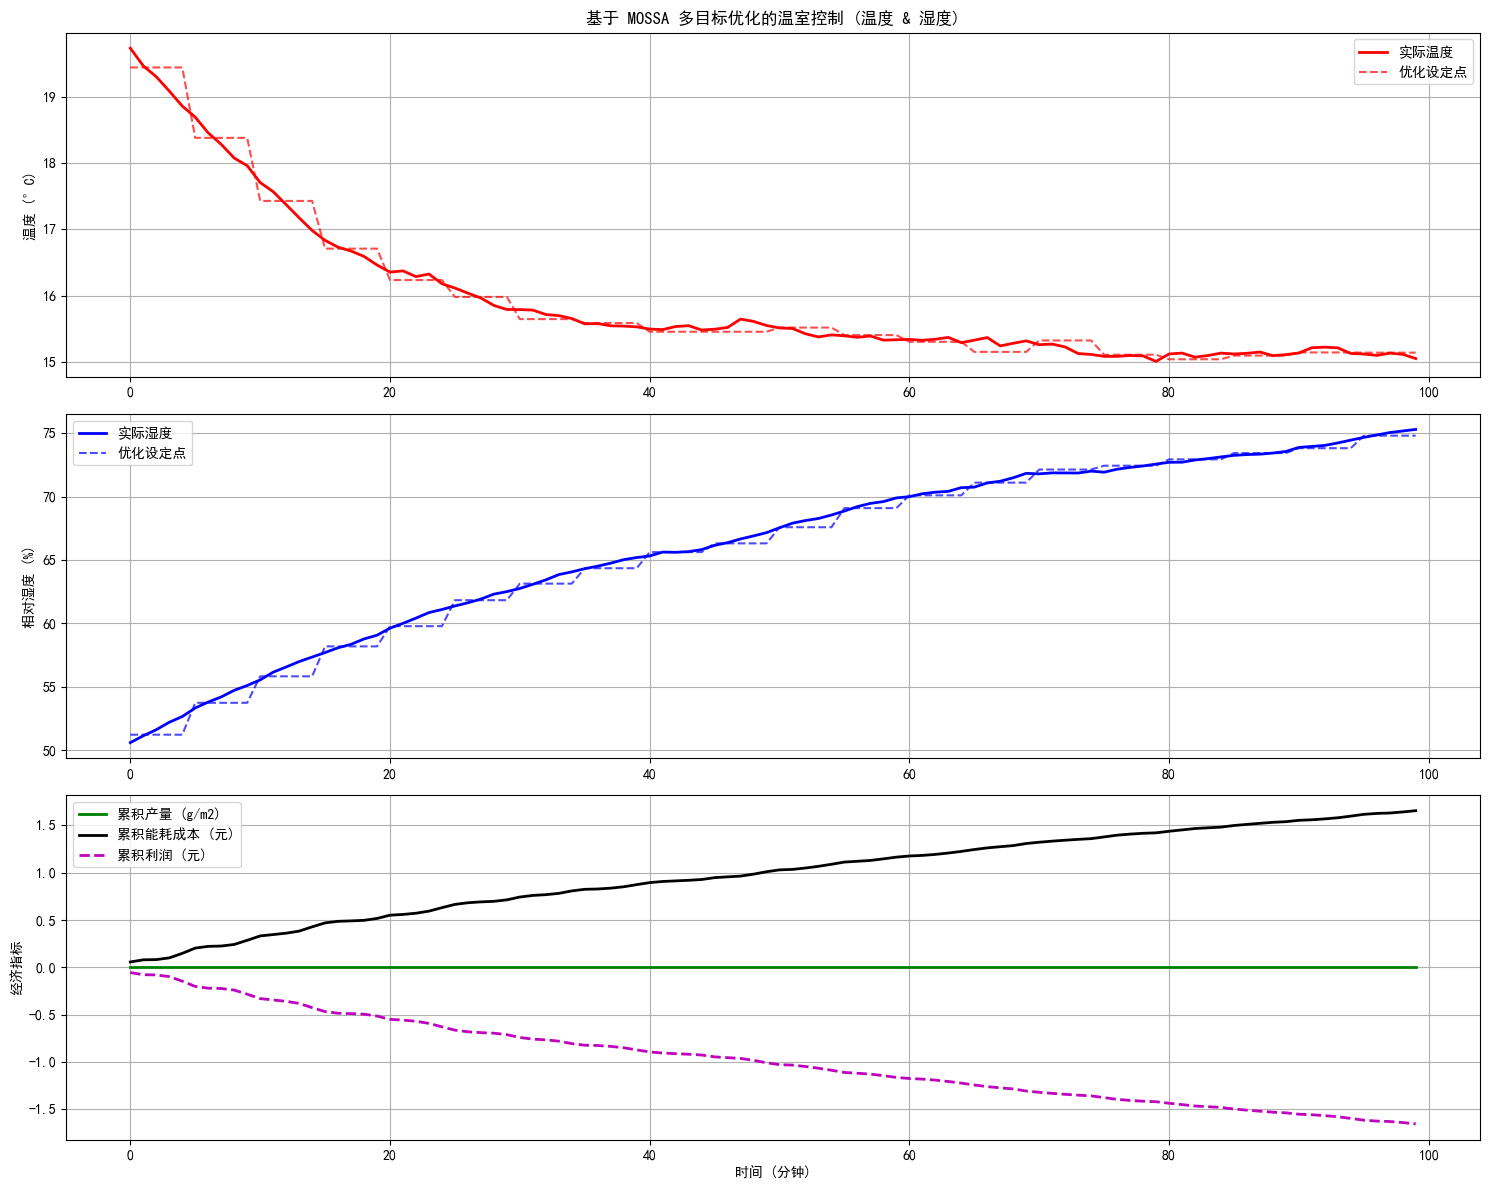

In [6]:
# 绘制结果
plt.figure(figsize=(15, 12))

# 1. 温度控制效果
plt.subplot(3, 1, 1)
plt.plot(history['time'], history['temp'], 'r-', label='实际温度', linewidth=2)
plt.plot(history['time'], history['target_temp'], 'r--', label='优化设定点', alpha=0.7)
plt.ylabel('温度 (°C)')
plt.title('基于 MOSSA 多目标优化的温室控制 (温度 & 湿度)')
plt.legend()
plt.grid(True)

# 2. 湿度控制效果
plt.subplot(3, 1, 2)
plt.plot(history['time'], history['rh'], 'b-', label='实际湿度', linewidth=2)
plt.plot(history['time'], history['target_rh'], 'b--', label='优化设定点', alpha=0.7)
plt.ylabel('相对湿度 (%)')
plt.legend()
plt.grid(True)

# 3. 经济效益 (累积产量 vs 累积成本)
plt.subplot(3, 1, 3)
plt.plot(history['time'], history['yield'], 'g-', label='累积产量 (g/m2)', linewidth=2)
plt.plot(history['time'], history['cost'], 'k-', label='累积能耗成本 (元)', linewidth=2)
# 计算利润
profit = np.array(history['yield']) * 2.0 - np.array(history['cost'])
plt.plot(history['time'], profit, 'm--', label='累积利润 (元)', linewidth=2)

plt.xlabel('时间 (分钟)')
plt.ylabel('经济指标')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [7]:
# === 5. 定量评估报告 ===
# 这部分的变量名需要根据新的 history 字典进行调整

# 从 history 字典提取数据
h_temp = np.array(history['temp'])
h_target_temp = np.array(history['target_temp'])
h_rh = np.array(history['rh'])
h_target_rh = np.array(history['target_rh'])
h_u_temp = np.array(history['u_temp'])
h_u_rh = np.array(history['u_rh'])

# 计算误差指标
temp_error = h_temp - h_target_temp
rh_error = h_rh - h_target_rh

rmse_temp = np.sqrt(np.mean(temp_error**2))
rmse_rh = np.sqrt(np.mean(rh_error**2))

mae_temp = np.mean(np.abs(temp_error))
mae_rh = np.mean(np.abs(rh_error))

print(f"=== 控制效果定量评估 (Steps: {total_steps}) ===")
print(f"温度指标:")
print(f"  RMSE: {rmse_temp:.4f} °C")
print(f"  MAE:  {mae_temp:.4f} °C")
print(f"  Max Error: {np.max(np.abs(temp_error)):.4f} °C")
print("-" * 30)
print(f"湿度指标:")
print(f"  RMSE: {rmse_rh:.4f} %")
print(f"  MAE:  {mae_rh:.4f} %")
print(f"  Max Error: {np.max(np.abs(rh_error)):.4f} %")
print("-" * 30)

# 评估控制平稳性 (计算控制量的标准差)
std_u_t = np.std(h_u_temp)
std_u_r = np.std(h_u_rh)
print(f"控制平稳性 (输出标准差):")
print(f"  U_Temp Std: {std_u_t:.4f}")
print(f"  U_RH Std:   {std_u_r:.4f}")

# 经济指标总结
total_profit = history['yield'][-1] * 2.0 - history['cost'][-1]
print("-" * 30)
print(f"经济效益总结:")
print(f"  总产量: {history['yield'][-1]:.2f} g/m2")
print(f"  总能耗: {history['cost'][-1]:.2f} 元")
print(f"  净利润: {total_profit:.2f} 元")

=== 控制效果定量评估 (Steps: 100) ===
温度指标:
  RMSE: 0.1429 °C
  MAE:  0.0994 °C
  Max Error: 0.5830 °C
------------------------------
湿度指标:
  RMSE: 0.5241 %
  MAE:  0.3935 %
  Max Error: 1.5192 %
------------------------------
控制平稳性 (输出标准差):
  U_Temp Std: 0.3400
  U_RH Std:   0.7648
------------------------------
经济效益总结:
  总产量: 0.00 g/m2
  总能耗: 1.65 元
  净利润: -1.65 元
